In [ ]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns

from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

train_file_id = '1dKmNWf77YdHDqgwajxezHzR5B28szenW'
test_file_id = '13uSJNp-Zpo6Bo--R4fde8ypN4lVe6oB2'

train_download = drive.CreateFile({'id': train_file_id})
test_download = drive.CreateFile({'id': test_file_id})

# Download the file to a local disc
train_download.GetContentFile('train_file.csv')
test_download.GetContentFile('test_file.csv')

# Specify the data type for the problematic column (e.g., as 'str' if it should be a string)
# If you're not sure about the correct data type, you can use 'str' to read everything as strings and then process it later.
dtype_dict = {6: 'str'}

train_df = pd.read_csv("train_file.csv", dtype=dtype_dict, low_memory=False)
test_df = pd.read_csv("test_file.csv", dtype=dtype_dict, low_memory=False)


In [ ]:
train_df.head()
print(test_df)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0     1461          20       RH         80.0    11622   Pave   NaN      Reg   
1     1462          20       RL         81.0    14267   Pave   NaN      IR1   
2     1463          60       RL         74.0    13830   Pave   NaN      IR1   
3     1464          60       RL         78.0     9978   Pave   NaN      IR1   
4     1465         120       RL         43.0     5005   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1454  2915         160       RM         21.0     1936   Pave   NaN      Reg   
1455  2916         160       RM         21.0     1894   Pave   NaN      Reg   
1456  2917          20       RL        160.0    20000   Pave   NaN      Reg   
1457  2918          85       RL         62.0    10441   Pave   NaN      Reg   
1458  2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities  ... ScreenPorch PoolAre

# Data Preprocessing and visualization

In [ ]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

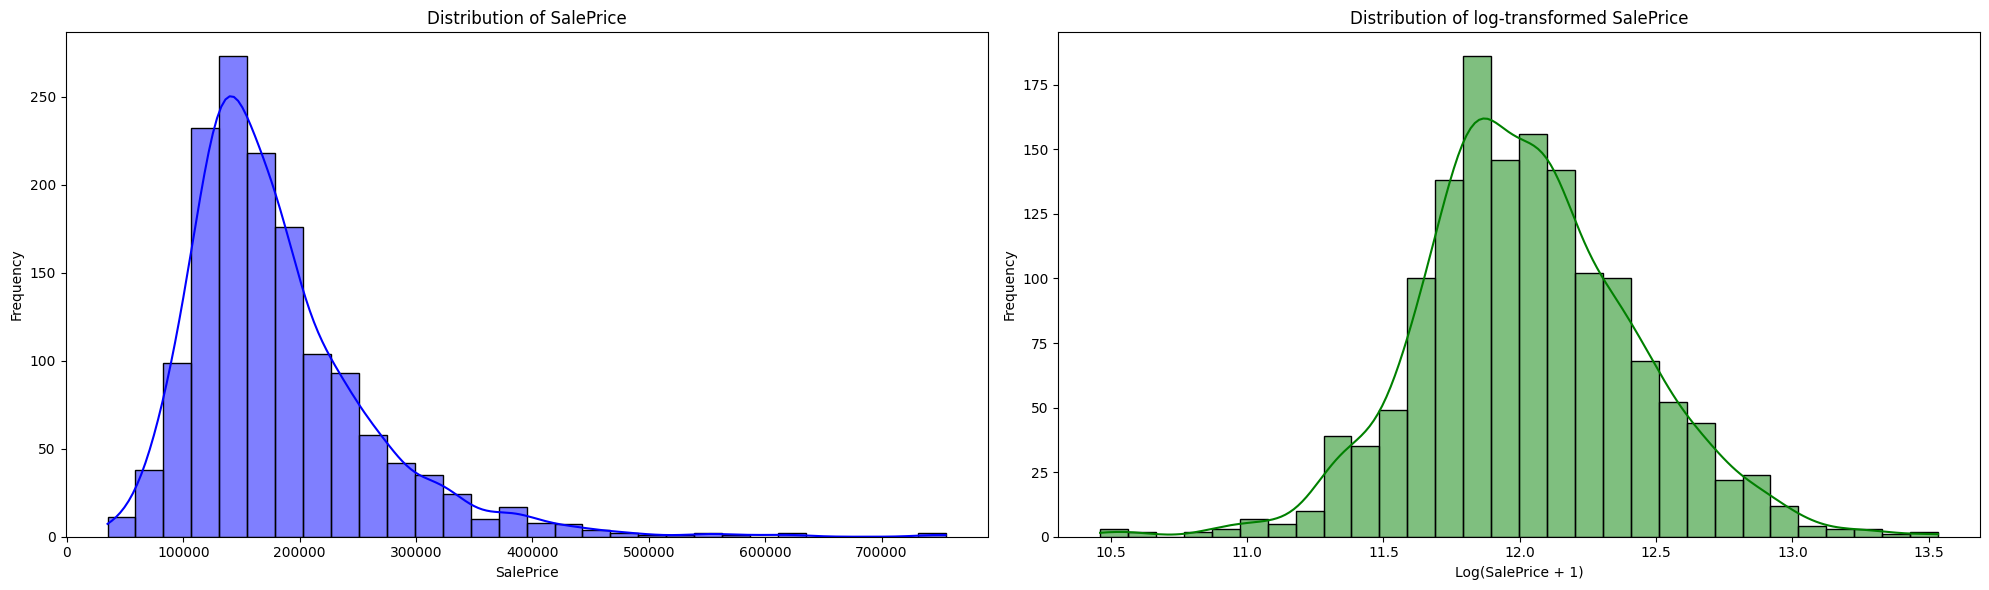

In [ ]:
import numpy as np

# Recreate the plots with numpy imported

# Distribution of 'SalePrice'
plt.figure(figsize=(20, 6))

# Subplot for distribution
plt.subplot(1, 2, 1)
sns.histplot(train_df['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')

# Subplot for log transformation
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(train_df['SalePrice']), kde=True, bins=30, color='green')
plt.title('Distribution of log-transformed SalePrice')
plt.xlabel('Log(SalePrice + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Return the percentage of missing data for further analysis


drop columns with too high missing rate

In [ ]:
#drop columns with too high missing rate
train_df_drop=train_df.drop(columns = ['MiscFeature','PoolQC', 'Fence', 'Alley', "FireplaceQu", 'SalePrice', 'Id'], axis = 1)
#train_df_drop=train_df.drop(columns = ['MiscFeature','PoolQC', 'Fence', 'Alley', "FireplaceQu", 'Id'], axis = 1)
test_df_drop=test_df.drop(columns = ['MiscFeature','PoolQC','Fence','Alley', "FireplaceQu", 'Id'], axis = 1)

train_df_drop.head()

y_train = train_df['SalePrice']



Visualize missing data

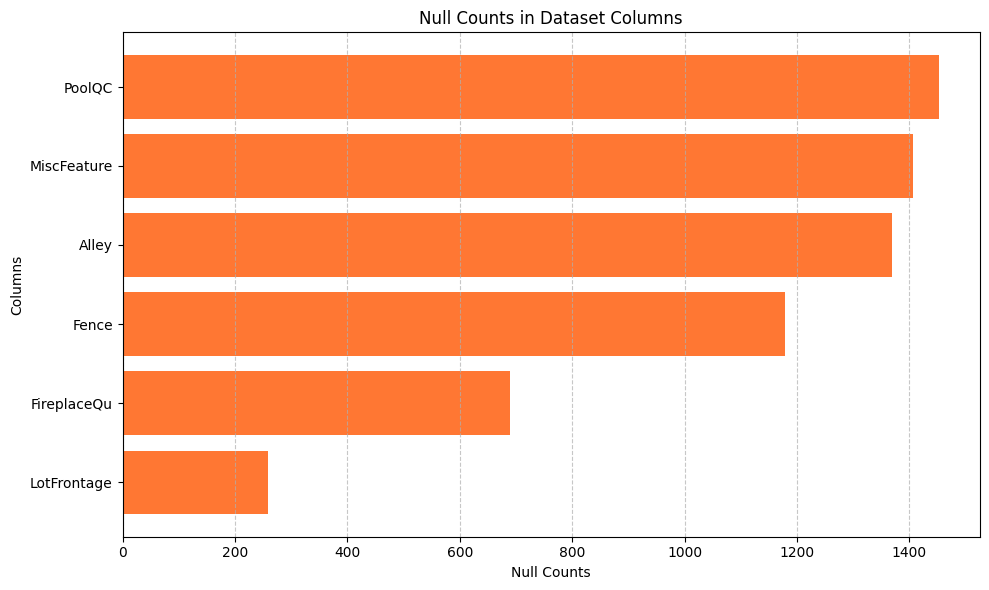

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [ ]:
null_count_columns = train_df[['MiscFeature','PoolQC', 'Fence', 'Alley', "FireplaceQu", 'LotFrontage']].isnull().sum()

null_counts_df = pd.DataFrame(list(null_count_columns.items()), columns=["Column", "NullCount"])

null_counts_df.sort_values(by="NullCount", inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(null_counts_df["Column"], null_counts_df["NullCount"], color="#FF7733")
plt.xlabel("Null Counts")
plt.ylabel("Columns")
plt.title("Null Counts in Dataset Columns")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

train_df_drop.info()
test_df_drop.info()

Encode categorial columnns

In [ ]:
# Feature Engineering: Assigning values
def assign_values(df):
    housestyle_mapping = {
        '2Story': 5,
        '1Story': 4,
        '1.5Fin': 3,
        'SLvl': 4,
        'SFoyer': 3,
        '2.5Unf': 2,
        '1.5Unf': 1,
        '2.5Fin': 6
    }
    df['HouseStyle'] = df['HouseStyle'].map(housestyle_mapping)

    foundation_mapping = {
        'PConc': 5,
        'CBlock': 4,
        'BrkTil': 3,
        'Wood': 2,
        'Slab': 1,
        'Stone': 6
    }
    df['Foundation'] = df['Foundation'].map(foundation_mapping)



    return df


In [ ]:
'''
ordinal_features = [
    "OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual",
    "GarageQual", "GarageCond", "LotShape", "LandSlope", "BsmtExposure", "BsmtFinType1",
    "BsmtFinType2", "Functional", "GarageFinish", "PavedDrive", "Utilities", "CentralAir", "Electrical"
]
'''
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

def preprocess_and_select_features(df):
    #df = assign_values(df)

    # Handle missing values
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].median())

    for col in df.select_dtypes(exclude=[np.number]).columns:
        df[col] = df[col].fillna(df[col].mode()[0])

    # Encode categorical columns
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])

    return df

df_train_drop = preprocess_and_select_features(train_df_drop)
df_test_drop = preprocess_and_select_features(test_df_drop)

df_train_drop.info()
df_test_drop.info()

print(df_train_drop.head())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int64  
 5   LotShape       1460 non-null   int64  
 6   LandContour    1460 non-null   int64  
 7   Utilities      1460 non-null   int64  
 8   LotConfig      1460 non-null   int64  
 9   LandSlope      1460 non-null   int64  
 10  Neighborhood   1460 non-null   int64  
 11  Condition1     1460 non-null   int64  
 12  Condition2     1460 non-null   int64  
 13  BldgType       1460 non-null   int64  
 14  HouseStyle     1460 non-null   int64  
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [ ]:
'''
df_train_encoded = pd.get_dummies(df_train_drop, drop_first=True)
df_test_encoded = pd.get_dummies(df_test_drop, drop_first=True)
df_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='left', axis=1)  # aligning test to train
df_test_encoded.fillna(0, inplace=True)

df_train_drop = df_train_encoded
df_test_drop = df_test_encoded
'''


"\ndf_train_encoded = pd.get_dummies(df_train_drop, drop_first=True)\ndf_test_encoded = pd.get_dummies(df_test_drop, drop_first=True)\ndf_train_encoded, df_test_encoded = df_train_encoded.align(df_test_encoded, join='left', axis=1)  # aligning test to train\ndf_test_encoded.fillna(0, inplace=True)\n\ndf_train_drop = df_train_encoded\ndf_test_drop = df_test_encoded\n"

Outliers

In [ ]:
'''
from scipy import stats

# Make a copy of df_train_drop to preserve the original data
train_data = df_train_drop.copy()

# Remove 'SalePrice' before calculating z-scores for features
features = train_data.drop(columns=['SalePrice'])

# Calculate z-scores only for the feature columns
z_scores = np.abs(stats.zscore(features.select_dtypes(include=[np.number])))

# Identify rows that do not contain outliers
no_outliers = (z_scores < 4).all(axis=1)
print(no_outliers)

# Filter the original dataframe to only include rows without outliers
train_df_no_outliers = train_data[no_outliers]
print(train_df_no_outliers.head(5))
# Separate features and target variable after removing outliers
X_train_no_outliers = train_df_no_outliers.drop(columns=['SalePrice'], axis=1)
y_train_no_outliers = train_df_no_outliers['SalePrice']

print(X_train_no_outliers.head(5))
'''

"\nfrom scipy import stats\n\n# Make a copy of df_train_drop to preserve the original data\ntrain_data = df_train_drop.copy()\n\n# Remove 'SalePrice' before calculating z-scores for features\nfeatures = train_data.drop(columns=['SalePrice'])\n\n# Calculate z-scores only for the feature columns\nz_scores = np.abs(stats.zscore(features.select_dtypes(include=[np.number])))\n\n# Identify rows that do not contain outliers\nno_outliers = (z_scores < 4).all(axis=1)\nprint(no_outliers)\n\n# Filter the original dataframe to only include rows without outliers\ntrain_df_no_outliers = train_data[no_outliers]\nprint(train_df_no_outliers.head(5))\n# Separate features and target variable after removing outliers\nX_train_no_outliers = train_df_no_outliers.drop(columns=['SalePrice'], axis=1)\ny_train_no_outliers = train_df_no_outliers['SalePrice']\n\nprint(X_train_no_outliers.head(5))\n"

Impute missing val & normalize val

In [ ]:
#Impute missing val & normalize val
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='mean')
df_train_drop_imputed = imputer.fit_transform(df_train_drop)
#df_train_drop_imputed = imputer.fit_transform(X_train_no_outliers)
df_test_drop_imputed = imputer.transform(df_test_drop)

# Convert the imputed arrays back to DataFrames and reassign column names
df_train_drop_imputed = pd.DataFrame(df_train_drop_imputed, columns=df_train_drop.columns)
#df_train_drop_imputed = pd.DataFrame(df_train_drop_imputed, columns=X_train_no_outliers.columns)
df_test_drop_imputed = pd.DataFrame(df_test_drop_imputed, columns=df_test_drop.columns)


# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the scaler on the training data
df_train_drop_imputed_scaled = scaler.fit_transform(df_train_drop_imputed)

# Transform the test data using the same scaler
df_test_drop_imputed_scaled = scaler.transform(df_test_drop_imputed)

# Convert the scaled arrays back to DataFrames with column names
df_train_scaled = pd.DataFrame(df_train_drop_imputed_scaled, columns=df_train_drop_imputed.columns)
df_test_scaled = pd.DataFrame(df_test_drop_imputed_scaled, columns=df_test_drop_imputed.columns)

#print(df_train_scaled.info())


RFE

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

model = RandomForestRegressor()
# Initialize RFE
rfe = RFE(model, n_features_to_select=25)  # Select the number of features you want

# Fit RFE to your one-hot encoded data
rfe.fit(df_train_scaled, y_train)


RFE(estimator=RandomForestRegressor(), n_features_to_select=25)

In [ ]:
# Get the selected features
selected_features = df_train_scaled.columns[rfe.support_]
print(selected_features)

df_train_encoded_RFE = df_train_drop[selected_features]
df_test_encoded_RFE = df_test_drop[selected_features]

Index(['LotFrontage', 'LotArea', 'Neighborhood', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtQual', 'BsmtFinSF1',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold'],
      dtype='object')


In [ ]:
#correlation matrix


In [ ]:
#df_train_encoded_RFE = df_train_encoded_RFE.drop(['Exterior1st', 'Exterior2nd'], axis = 1)
#df_test_encoded_RFE = df_test_encoded_RFE.drop(['Exterior1st', 'Exterior2nd'], axis = 1)


# Random Forest regression

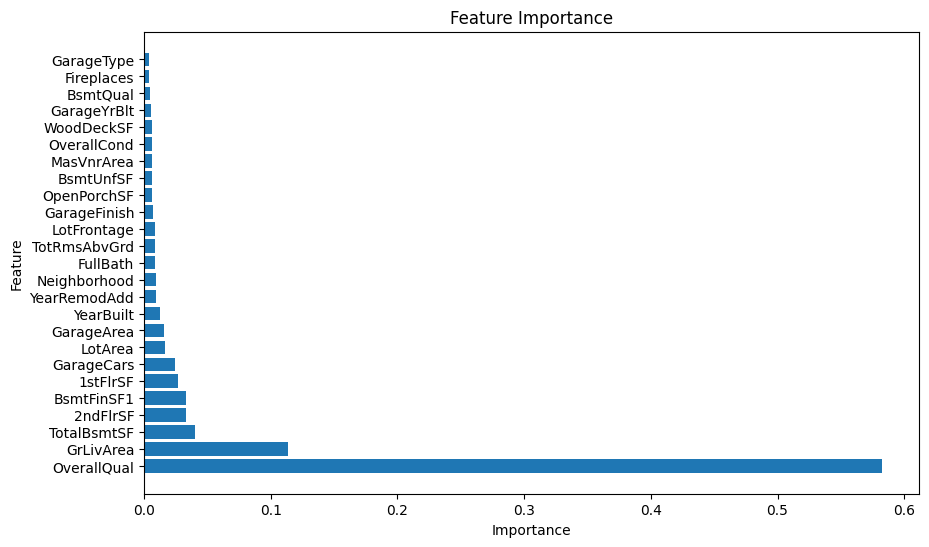

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Create a RandomForestRegressor model (you can also use DecisionTreeRegressor for a single tree)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(df_train_encoded_RFE, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature names and their importance scores
importances_df = pd.DataFrame({'Feature': df_train_encoded_RFE.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

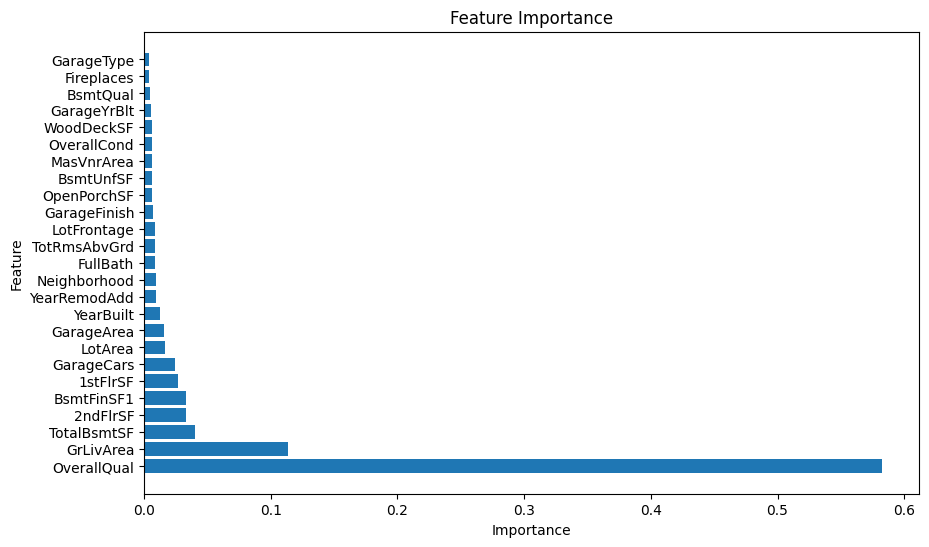

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Create a RandomForestRegressor model (you can also use DecisionTreeRegressor for a single tree)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(df_train_encoded_RFE, y_train)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to display feature names and their importance scores
importances_df = pd.DataFrame({'Feature': df_train_encoded_RFE.columns, 'Importance': feature_importances})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


predictions = model.predict(df_test_encoded_RFE)

In [ ]:
test_ids = test_df['Id']
#print(test_ids)
# Create a dataframe for submission
submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': predictions
})

# Save the dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)

from google.colab import files
files.download('submission.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Gradient Boosting

Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor  # Import GradientBoostingRegressor

# Create a GradientBoostingRegressor model
model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03,
                                     max_depth=5, max_features='sqrt',
                                     min_samples_leaf=10, min_samples_split=4,
                                     loss='huber', random_state=42)

# Fit the model to your training data
model.fit(df_train_encoded_RFE, y_train)

# Make predictions on the test data
predictions_gb = model.predict(df_test_encoded_RFE)

# The 'predictions' variable now contains the regression predictions for your test data

In [ ]:
test_ids = test_df['Id']
#print(test_ids)
# Create a dataframe for submission
submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': predictions_gb
})

# Save the dataframe to a CSV file
submission_df.to_csv('submission_gb.csv', index=False)

from google.colab import files
files.download('submission_gb.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Feature importance

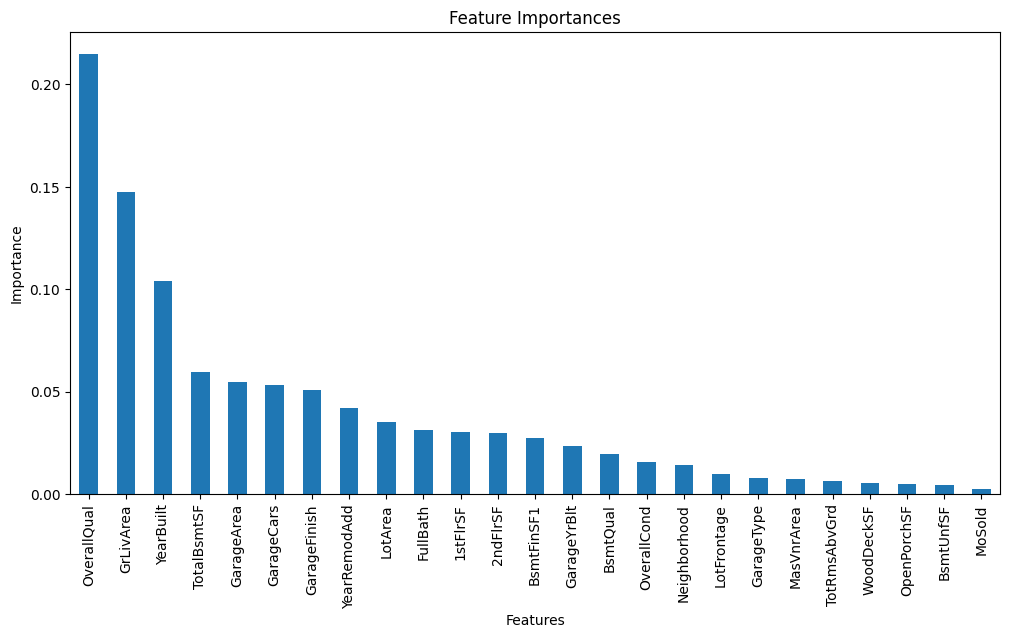

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'model' is your trained Gradient Boosting model
feature_importance = model.feature_importances_

# Convert the importance into one-dimensional 1darray with corresponding df column names as axis labels
f_importance = pd.Series(feature_importance, index=df_train_encoded_RFE.columns)

# Sort the array in descending order of the importances
f_importance.sort_values(ascending=False, inplace=True)

# Plot the feature importances
plt.figure(figsize=(12, 6))
f_importance.plot(kind='bar', title='Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()


Learning Curve

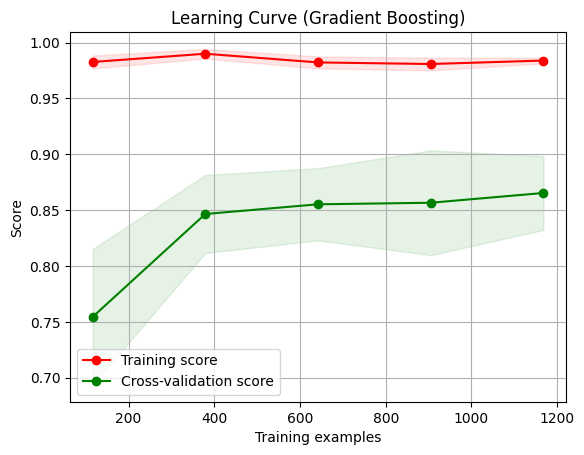

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum y-values plotted.

    cv : int, cross-validation generator, or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        - None means 1 unless in a joblib.parallel_backend context.
        - -1 means using all processors.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to generate the learning curve.
        If the dtype is float, it is regarded as a fraction of the maximum size of the training set (that is determined by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Assuming 'X_train' and 'y_train' are your training data and labels
plot_learning_curve(model, "Learning Curve (Gradient Boosting)", df_train_encoded_RFE, y_train, cv=5)
plt.show()
